## Import Packages

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from scipy import stats
import numpy as np


from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.metrics import mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.utils import check_random_state
#from stability_selection import StabilitySelection
from sklearn.linear_model import LinearRegression
import statistics 
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.svm import SVR
from sklearn import metrics


%matplotlib inline

## Import Data

In [5]:
#import
Data = pd.read_csv(r'C:\Users\Preston\Combined Flowcals2.csv')  # importing the csv file

#Drop Useless Features
Data = Data.drop(['N2','Pressure','Temp','CO2','iC5'],axis=1)  # Replace 'N2', 'Pressure', etc. with any features -
                                                                # you don't want to use in your model
Data = (Data).astype(float) #make sure all data is type float
names = list(Data.columns) #saving column names



Data.head()

,SG,C1,C2,C3,iC4,C4,C5,C6,C7,MW
0,0.799164,0.1860,0.5045,1.6330,0.6250,2.7600,3.132,5.963,83.3495,151.494304
1,0.746170,0.0920,0.6805,1.9165,1.0005,2.9215,3.660,9.114,77.9120,120.984780
2,0.743256,0.0515,0.6295,1.7860,0.9895,2.8500,3.702,9.396,77.7945,119.562038
3,0.728216,0.0955,0.7335,2.0560,1.1800,3.3735,4.158,10.481,74.7175,109.503770
4,0.722747,0.0745,0.6565,1.8785,1.1075,3.1220,4.074,11.031,74.9760,106.965828


In [35]:
#split data into test and train sets
X = Data[['SG', 'C1', 'C2', 'C3', 'iC4', 'C5', 'C6', 'C7']].values
y = Data['MW'].values # the value you want to model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #set test/train split

## could scale data here if necessary - I skipped that step here



## Using Cross-Validation to Generate Generalizable Models

In [18]:
#Cross Validation function - avoids overfitting
n_folds = 6

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [19]:
# Selecting Models and Hyperparameters to test

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.05, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.05, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.1,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

m_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

svr = SVR(gamma='scale', C=10.0, epsilon=0.1)

In [37]:
## Looking at RMSE and Cross Validation Results

## Mean score and 95% confidence interval

score = rmse_cv(lasso)
print("\nLasso Accuracy: {:.4f} (+/- {:.4f})\n".format(score.mean(), score.std() * 2))

score = rmse_cv(ENet)
print("ElasticNet Accuracy: {:.4f} (+/- {:.4f})\n".format(score.mean(), score.std()  * 2))

score = rmse_cv(KRR)
print("Kernel Ridge Accuracy: {:.4f} (+/- {:.4f})\n".format(score.mean(), score.std() * 2))

score = rmse_cv(GBoost)
print("Gradient Boosting Accuracy: {:.4f} (+/- {:.4f})\n".format(score.mean(), score.std() * 2))

score = rmse_cv(m_xgb)
print("Xgboost Accuracy: {:.4f} (+/- {:.4f})\n".format(score.mean(), score.std() * 2))

score = rmse_cv(svr)
print("svr Accuracy: {:.4f} (+/- {:.4f})\n".format(score.mean(), score.std() * 2))


Lasso Accuracy: 3.4507 (+/- 1.4975)

ElasticNet Accuracy: 3.4509 (+/- 1.4667)

Kernel Ridge Accuracy: 3.6858 (+/- 3.0545)

Gradient Boosting Accuracy: 3.6778 (+/- 2.1190)

Xgboost Accuracy: 3.8537 (+/- 1.9562)

svr Accuracy: 5.7775 (+/- 0.7010)



## Combining Models
        Comparing Averaging vs Stacking

#### Averaging models

In [21]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [22]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso, m_xgb))

score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 2.9799 (0.4193)



#### Stacking Models

In [23]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=6):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

##### *This can take a while to run

In [24]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmse_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 3.1579 (0.5826)


## Looking at RMSE of models

In [ ]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [29]:
averaged_models.fit(X_train, y_train)
averaged_train_pred = averaged_models.predict(X_train)
averaged_test_pred = averaged_models.predict(X_test)

RMSE = np.sqrt(metrics.mean_squared_error(y_test, averaged_test_pred))
print("Final score (RMSE), averaged: {}".format(RMSE))

MAE = metrics.mean_absolute_error(y_test, averaged_test_pred)
print(("Final score (MAE), averaged: {}".format(MAE)))

r2 = metrics.r2_score(y_test, averaged_test_pred)
print(("Final score (r2), averaged: {}".format(r2)))



stacked_averaged_models.fit(X_train, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train)
stacked_pred = stacked_averaged_models.predict(X_test)
#print(rmse(y_train, stacked_train_pred))
#print(rmse(y_test, stacked_pred))

RMSE = np.sqrt(metrics.mean_squared_error(y_test, stacked_pred))
print("Final score (RMSE), stacked: {}".format(RMSE))

MAE = metrics.mean_absolute_error(y_test, stacked_pred)
print(("Final score (MAE), stacked: {}".format(MAE)))

r2 = metrics.r2_score(y_test, stacked_pred)
print(("Final score (r2), stacked: {}".format(r2)))

Final score (RMSE), averaged: 3.209783001639572
Final score (MAE), averaged: 2.122034031467255
Final score (r2), averaged: 0.917572519520765
Final score (RMSE), stacked: 3.211275938394433
Final score (MAE), stacked: 2.0861797329807295
Final score (r2), stacked: 0.9174958242215454


## Plot Results

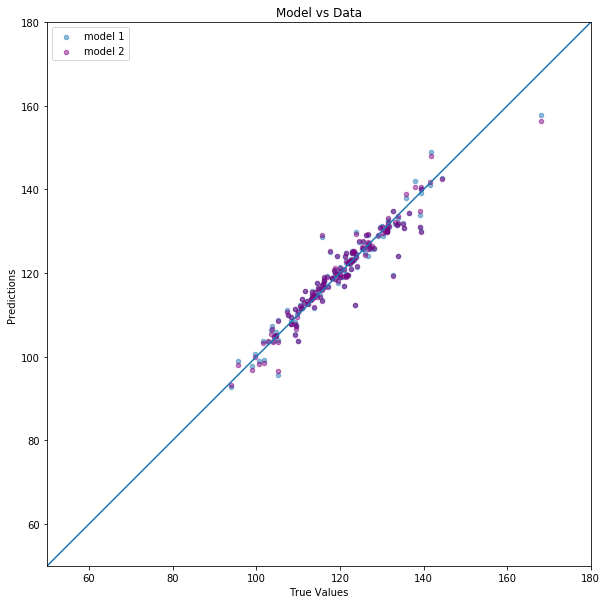

In [38]:
plt.figure(figsize=(20,10))


a = plt.axes(aspect='equal')
plt.scatter(y_test, averaged_test_pred, s = 20, alpha = 0.5, label = 'model 1')
plt.scatter(y_test, stacked_pred, color = 'purple', s = 20, alpha = 0.5, label = 'model 2')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [50, 180]   # change this so it fits your data, this is the graph size
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('Model vs Data')
plt.legend(loc="upper left")
plt.show()


## Send Results to a CSV file

In [50]:
results = pd.DataFrame(data=y_test, columns=["Real Values"])
results["model prediction"] = stacked_pred  # can add more results this way

results.to_csv(r'C:\Users\Preston\model results.csv') #save output csv wherever you want
results.head()

,Real Values,model prediction
0,116.104031,119.033401
1,127.039237,127.180155
2,122.044550,122.357501
3,135.215490,130.799785
4,110.684088,111.630292
